In [2]:
print("Hello, Colab!")

Hello, Colab!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [5]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/nvda/NVDA_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


        Price  Open Close  High       Volume
0      Ticker  NVDA  NVDA  NVDA         NVDA
1        Date   NaN   NaN   NaN          NaN
2  2020-06-09  8.77  9.01  9.07  468488000.0
3  2020-06-08  8.84  8.77  8.86  387736000.0
4  2020-06-05  8.76  8.89  8.96  481748000.0


In [6]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Price     0
Open      1
Close     1
High      1
Volume    1
dtype: int64
             Price  Open Close  High       Volume
count         2335  2334  2334  2334         2334
unique        2335   526   532   529         2316
top     2011-03-03  0.33  0.33  0.33  253792000.0
freq             1   101   107    90            2


In [7]:
import pandas as pd

# Step 1: Skip the first two junk rows and create a clean copy
data_cleaned = data.iloc[2:].copy()

# Step 2: Rename the 'Price' column to 'Date'
data_cleaned.rename(columns={'Price': 'Date'}, inplace=True)

# Step 3: Convert the 'Date' column to a proper datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Now, you can sort by the 'Date' column without an error
data_cleaned = data_cleaned.sort_values(by='Date', ascending=True)

# Optional: Convert other columns to numeric if needed
for col in ['Open', 'Close', 'High', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Display the head of the cleaned and sorted DataFrame
print(data_cleaned.head())

           Date  Open  Close  High        Volume
2334 2011-03-03  0.48   0.47  0.48  1.593704e+09
2333 2011-03-04  0.47   0.47  0.48  9.597600e+08
2332 2011-03-07  0.47   0.46  0.48  1.019140e+09
2331 2011-03-08  0.47   0.44  0.47  1.947184e+09
2330 2011-03-09  0.44   0.43  0.45  1.318976e+09


In [9]:
import pandas as pd

# --- FIX: Convert columns to a numeric type before calculations ---
# Use errors='coerce' to turn any non-numeric values into NaN (Not a Number)
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day's features
data['Movement'] = data['Movement'].shift(1)

# Drop rows with NaN values that were created during calculations
data = data.dropna(subset=['Movement'])

# Convert Movement into a binary target variable (1 for up, 0 for down/flat)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print("Distribution of the 'Movement' target variable:")
print(data['Movement'].value_counts().sort_index())

Distribution of the 'Movement' target variable:
Movement
0    1511
1     821
Name: count, dtype: int64


In [10]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [11]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [12]:
data.tail(20)


,Price,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2315,2011-03-30,0.44,0.42,0.44,1176320000.0,1,0.000000,1.352779,0.42,0.42,655112000.0,2.439024,2.055339
2316,2011-03-29,0.44,0.43,0.44,715764000.0,1,2.380952,1.337102,0.42,0.44,1176320000.0,0.000000,1.352779
2317,2011-03-28,0.43,0.44,0.45,1204284000.0,0,2.325581,1.080364,0.43,0.44,715764000.0,2.380952,1.337102
2318,2011-03-25,0.44,0.42,0.44,1196392000.0,0,-4.545455,3.013932,0.44,0.45,1204284000.0,2.325581,1.080364
2319,2011-03-24,0.41,0.44,0.44,1780592000.0,0,4.761905,3.520192,0.42,0.44,1196392000.0,-4.545455,3.013932
2320,2011-03-23,0.39,0.40,0.4,782396000.0,0,-9.090909,5.778937,0.44,0.44,1780592000.0,4.761905,3.520192
2321,2011-03-22,0.40,0.40,0.4,718332000.0,0,0.000000,5.541035,0.40,0.4,782396000.0,-9.090909,5.778937
2322,2011-03-21,0.41,0.40,0.41,751832000.0,1,0.000000,5.249531,0.40,0.4,718332000.0,0.000000,5.541035
2323,2011-03-18,0.41,0.40,0.41,886960000.0,1,0.000000,5.039154,0.40,0.41,751832000.0,0.000000,5.249531
2324,2011-03-17,0.41,0.40,0.41,1238516000.0,1,0.000000,4.065578,0.40,0.41,886960000.0,0.000000,5.039154


In [13]:
data.rename(columns={'Price': 'Date'}, inplace=True)

In [14]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [15]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.142332
Close_lag1           0.117486
High_lag1            0.123410
Volume_lag1          0.117324
Daily_Return_lag1   -0.053038
Volatility_lag1      0.102784
Name: Movement, dtype: float64


In [16]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


    Open  Close_lag1 High_lag1   Volume_lag1  Daily_Return_lag1  \
9   8.52        8.77       8.8   389876000.0          -0.227531   
10  8.38        8.84      8.84   745256000.0           0.798176   
11  8.59        8.45      8.72   734896000.0          -4.411765   
12  9.12        8.49       8.6  1175892000.0           0.473373   
13  8.79        8.68      9.14   770780000.0           2.237927   

    Volatility_lag1  
9          1.186951  
10         1.041836  
11         2.158446  
12         2.202952  
13         2.506473  
9     0
10    0
11    1
12    1
13    1
Name: Movement, dtype: int64


In [17]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-03-16', '2011-03-15', '2011-03-14', '2011-03-11',
               '2011-03-10', '2011-03-09', '2011-03-08', '2011-03-07',
               '2011-03-04', '2011-03-03'],
              dtype='datetime64[ns]', name='Date', length=2326, freq=None)


In [18]:
X.index = data.index
print(X.index)

DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-03-16', '2011-03-15', '2011-03-14', '2011-03-11',
               '2011-03-10', '2011-03-09', '2011-03-08', '2011-03-07',
               '2011-03-04', '2011-03-03'],
              dtype='datetime64[ns]', name='Date', length=2326, freq=None)


In [19]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-11-07 to 2020-05-29
Test Dates: 2017-04-27 to 2018-11-06
--------------------------------------------------
Fold 2:
Train Dates: 2017-04-27 to 2020-05-29
Test Dates: 2015-10-13 to 2017-04-26
--------------------------------------------------
Fold 3:
Train Dates: 2015-10-13 to 2020-05-29
Test Dates: 2014-04-01 to 2015-10-12
--------------------------------------------------
Fold 4:
Train Dates: 2014-04-01 to 2020-05-29
Test Dates: 2012-09-13 to 2014-03-31
--------------------------------------------------
Fold 5:
Train Dates: 2012-09-13 to 2020-05-29
Test Dates: 2011-03-03 to 2012-09-12
--------------------------------------------------


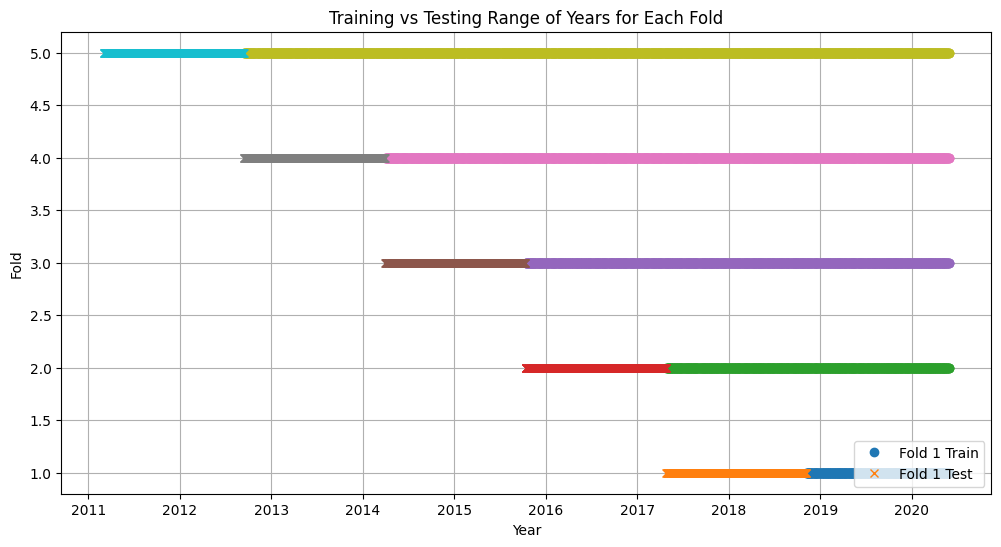

In [20]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[212   1]
 [ 71 103]]


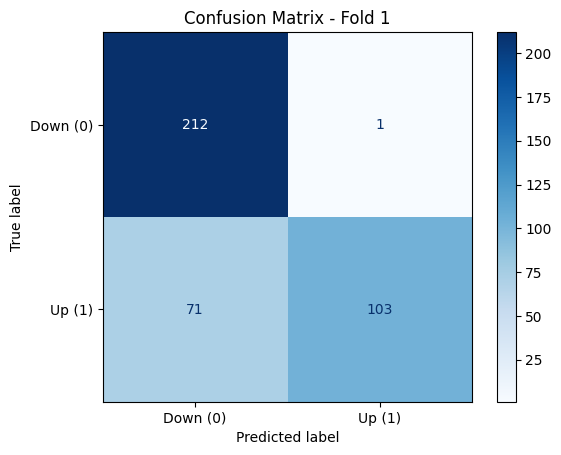

Fold 1 Accuracy: 0.81
--------------------------------------------------

Fold 2 Confusion Matrix:
[[242   8]
 [ 70  67]]


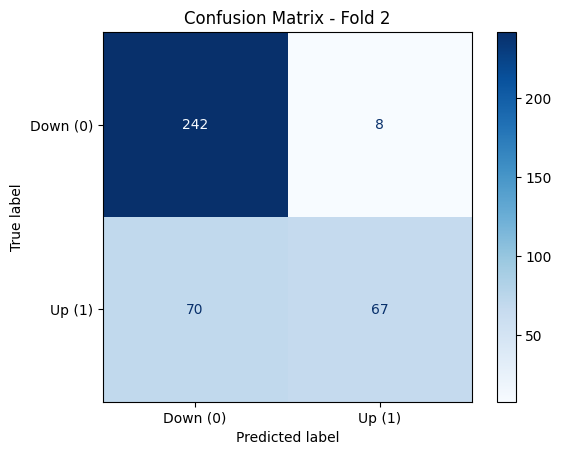

Fold 2 Accuracy: 0.80
--------------------------------------------------

Fold 3 Confusion Matrix:
[[274   0]
 [112   1]]


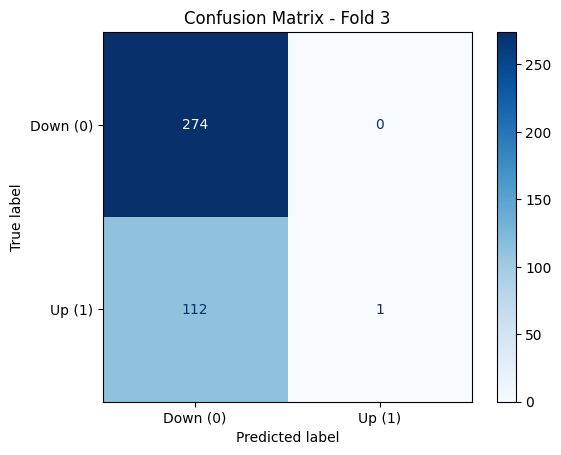

Fold 3 Accuracy: 0.71
--------------------------------------------------

Fold 4 Confusion Matrix:
[[304   0]
 [ 83   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


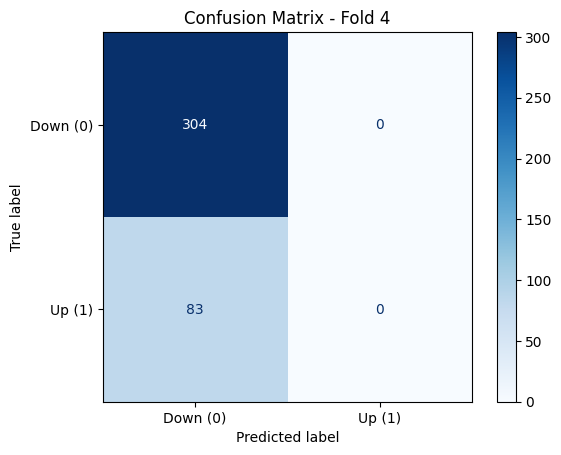

Fold 4 Accuracy: 0.79
--------------------------------------------------

Fold 5 Confusion Matrix:
[[239   6]
 [136   6]]


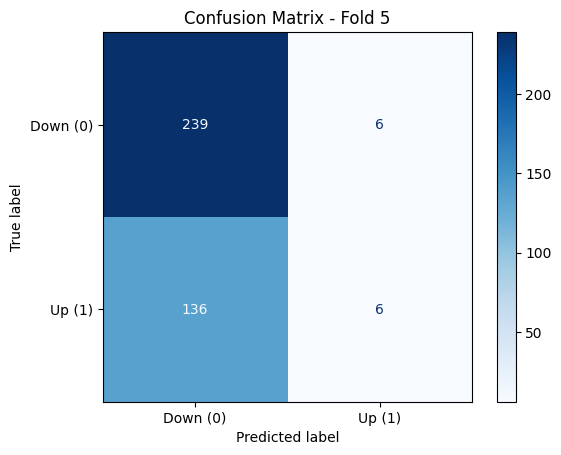

Fold 5 Accuracy: 0.63
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.75
Precision: 0.68
Recall: 0.23
F1-Score: 0.29
ROC-AUC: 0.80


In [21]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 - Balanced Class Distribution:
Movement
0    169
1    169
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[196  17]
 [ 28 146]]


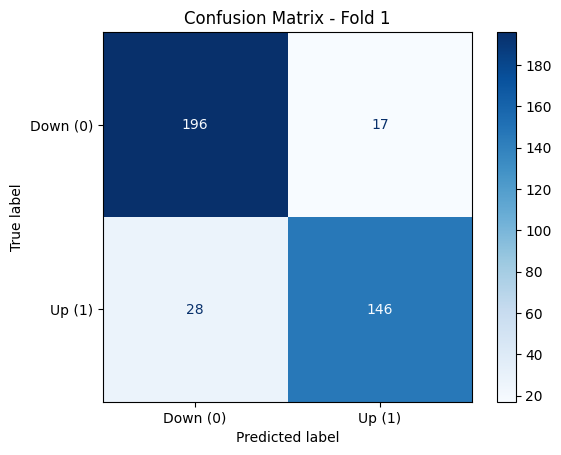

Fold 1 Accuracy: 0.88
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    343
1    343
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[184  66]
 [  2 135]]


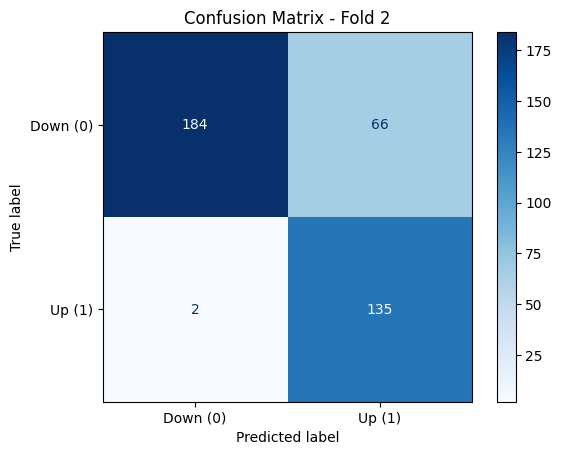

Fold 2 Accuracy: 0.82
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    480
1    480
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[268   6]
 [104   9]]


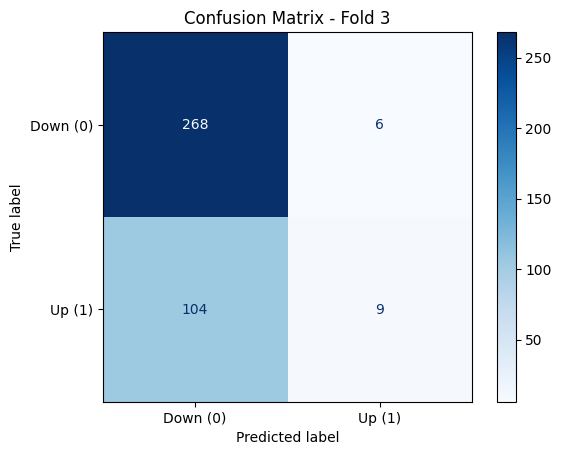

Fold 3 Accuracy: 0.72
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    593
1    593
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[272  32]
 [ 67  16]]


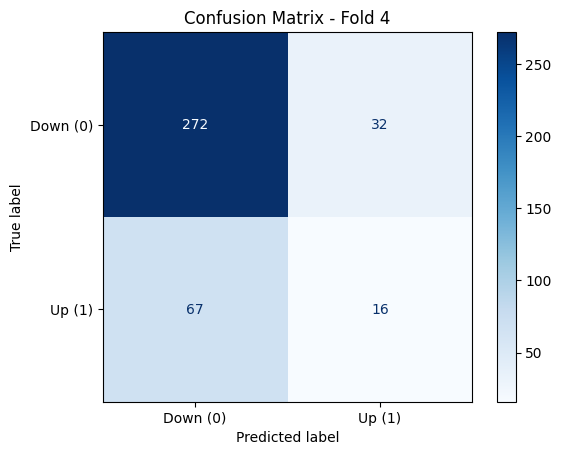

Fold 4 Accuracy: 0.74
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    676
1    676
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[152  93]
 [ 80  62]]


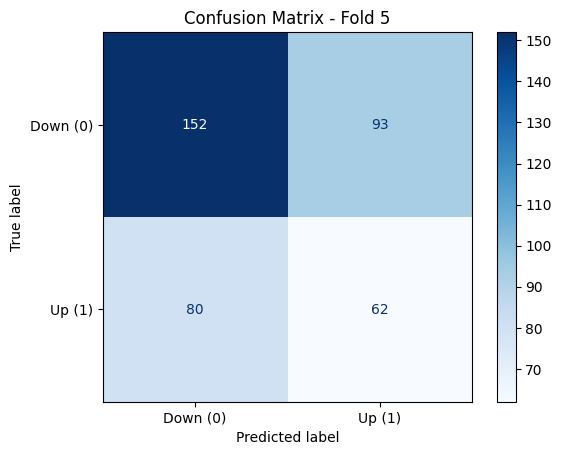

Fold 5 Accuracy: 0.55
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.74
Precision: 0.58
Recall: 0.51
F1-Score: 0.49
ROC-AUC: 0.79


In [22]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [23]:
data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/nvda/NVDA_numerical_LR.csv')